In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
import random
import os

Loading a pre trainedmodel and generating data based on 1000 default steps

In [3]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
image_pipe = DDPMPipeline.from_pretrained("./models/google/ddpm-celebahq-256")
image_pipe.to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch ./models/google/ddpm-celebahq-256: Error no file named diffusion_pytorch_model.safetensors found in directory ./models/google/ddpm-celebahq-256.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "./models/google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [ ]:
images = image_pipe().images
images[0]

Creating a scheduler with low inference steps to make generation faster 

In [5]:
# Create new scheduler and set num inference steps
scheduler = DDIMScheduler.from_pretrained("./models/google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

Generate images with new scheduler at various steps

In [ ]:
# The random starting point
x = torch.randn(4, 3, 256, 256).to(device)  # Batch of 4, 3-channel 256 x 256 px images

# Loop through the sampling timesteps
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare model input
    model_input = scheduler.scale_model_input(x, t)

    # Get the prediction
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Calculate what the updated sample should look like with the scheduler
    scheduler_output = scheduler.step(noise_pred, t, x)

    # Update x
    x = scheduler_output.prev_sample

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = scheduler_output.pred_original_sample  # Not available for all schedulers
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

In [ ]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=50).images
images[0]

Fine-tuning the model on custom datset (anime faces) :


Load dataset from disk

In [10]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Set seed for reproducibility
random.seed(42)

# List all image paths
all_images = [os.path.join("./data/anime_faces", img) for img in os.listdir("./data/anime_faces") if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Shuffle and split
random.shuffle(all_images)
split_ratio  = 0.8
split_index  =800#int(split_ratio * len(all_images))
train_images = all_images[:split_index]
test_images  = all_images[split_index:1000]

image_size = 256
batch_size = 64

# Define transform
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # scale to [-1, 1]
])

# Create datasets and dataloaders
train_dataset = CustomImageDataset(train_images, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomImageDataset(test_images, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

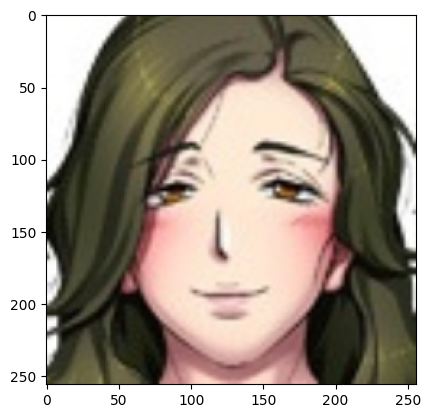

In [95]:
batch = next(iter(train_loader))
grid = torchvision.utils.make_grid(batch[0], nrow=1)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

In [11]:
num_epochs = 2  # @param
lr = 1e-4  # 2param
grad_accumulation_steps = 2  # @param
optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_loader), total=len(train_loader)):

        clean_images = batch.to(device)

        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(0, image_pipe.scheduler.num_train_timesteps, (bs,), device=clean_images.device,).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(
            noise_pred, noise
        )  # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)

        # Store for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch} average loss: {sum(losses[-len(train_loader):])/len(train_loader)}")

# Plot the loss curve:
plt.plot(losses)

  0%|          | 0/13 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 20.86 GiB is allocated by PyTorch, and 160.14 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)